# Jupyter notebook analyzing synaptic properties of GluA4, Stg, PSD95, and NR1 in 2024.08 Thy1-YFP dataset

Last edited by MES on 9/17/24

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/2024.08_Thy1-YFP_4target/'

In [5]:
filenames = os.listdir(parentdir)
csvs = [filename for filename in filenames if filename.endswith('csv')]

In [6]:
csvs

['ca1_selectedvsunselected_lmer_pvals.csv',
 'ssc_selectedvsunselected_lmer_pvals.csv']

In [7]:
mats = [filename for filename in filenames if filename.endswith('mat')]

In [8]:
mats

['analyzed_data_nofilt_20240904.mat',
 'analyzed_data_nofilt_20240901.mat',
 'analyzed_data_nofilt_20240916.mat']

In [9]:
matfile = sio.loadmat('analyzed_data_nofilt_20240916.mat',squeeze_me=True)

In [10]:
sorted(matfile.keys())

['__globals__', '__header__', '__version__', 'data']

In [11]:
matdata = matfile['data']

In [12]:
matdata

array((array(['Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn1',
       'Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn2',
       'Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn3', ...,
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64)], dtype=object), array([1.69024745e-05, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([101.,   0.,   0., ...,   0.,   0.,   0.]), array([1, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0.9370444, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ])),
      dtype=[('names', 'O'), ('total_vol', 'O'), ('mean_int', 'O'), ('npuncta', 'O'), ('selected_tf', 'O'), ('mean_int_refnorm', 'O')])

In [13]:
names = matdata['names'].item().tolist()

In [14]:
vols = matdata['total_vol'].item()
vols = np.reshape(vols, (vols.shape[0],1))

In [15]:
ints = matdata['mean_int'].item()
ints = np.reshape(ints, (ints.shape[0],1))

In [16]:
ns = matdata['npuncta'].item()
ns = np.reshape(ns, (ns.shape[0],1))

In [17]:
ints_refnorm = matdata['mean_int_refnorm'].item()
ints_refnorm = np.reshape(ints_refnorm, (ints_refnorm.shape[0],1))

In [18]:
selected_tfs = matdata['selected_tf'].item()
selected_tfs = np.reshape(selected_tfs, (selected_tfs.shape[0],1))

In [19]:
data_array = np.concatenate((vols,ints,ints_refnorm,ns,selected_tfs), axis=1)

In [20]:
data_array.shape

(283800, 5)

In [21]:
data = pd.DataFrame(data_array,index=names,
                    columns=['target_vol','target_meanint','target_meanint_refnorm','target_npuncta','selected_tf'])

In [22]:
data.tail(10)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0


In [23]:
data = data[data.index != '[]']

In [24]:
data

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn1,0.000017,101.000000,0.937044,1.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn2,0.000000,0.000000,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn3,0.000000,0.000000,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn4,0.000000,0.000000,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn5,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...
Thy1GFP_SSC_Stg_M2_001_fov011_pp_syn1121,0.000263,109.848624,36.728528,2.0,0.0
Thy1GFP_SSC_Stg_M2_001_fov011_pp_syn1122,0.000029,92.625000,3.368182,1.0,0.0
Thy1GFP_SSC_Stg_M2_001_fov011_pp_syn1123,0.000023,106.631579,2.841515,2.0,0.0
Thy1GFP_SSC_Stg_M2_001_fov011_pp_syn1124,0.000000,0.000000,0.000000,0.0,0.0


In [25]:
data.shape

(180486, 5)

In [26]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn1,0.000017,101.0,0.937044,1.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn2,0.000000,0.0,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn3,0.000000,0.0,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn4,0.000000,0.0,0.000000,0.0,0.0
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn5,0.000000,0.0,0.000000,0.0,0.0


In [27]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0.0    177931
1.0      2555
Name: count, dtype: int64

## 1. Add metadata

In [28]:
samples = []
regions = []
roi_fulls = []
fovs = [] 
syns = []
prots = []

for idx,row in data.iterrows():
    splits = idx.split("_")

    reg = splits[1]
    sample = splits[3]
    prot = splits[2]
    
    fov = splits[5]
    roi_full = sample + "-" + prot + "-" + fov
    syn = splits[7]
    
    samples.append(sample)
    regions.append(reg)
    roi_fulls.append(roi_full)
    fovs.append(fov)
    syns.append(syn)
    prots.append(prot)

In [29]:
unique(samples)

['M1', 'M2']

In [30]:
unique(regions)

['SSC', 'CA1']

In [31]:
data['sample'] = samples
data['region'] = regions
data['roi_full'] = roi_fulls
data['fov'] = fovs
data['syn'] = syns
data['prot'] = prots

In [32]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn1,0.000017,101.0,0.937044,1.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn1,GluA4
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn2,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn2,GluA4
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn3,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn3,GluA4
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn4,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn4,GluA4
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn5,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn5,GluA4


In [33]:
data.shape

(180486, 11)

In [34]:
selected_yns = []
for idx,row in data.iterrows():
    if row['selected_tf']:
        selected_yns.append('selected')
    else:
        selected_yns.append('unselected')

In [35]:
data['group']=selected_yns

## 1. GluA4

In [36]:
data_a4 = data[data['prot']=='GluA4']

<Axes: xlabel='target_vol', ylabel='Count'>

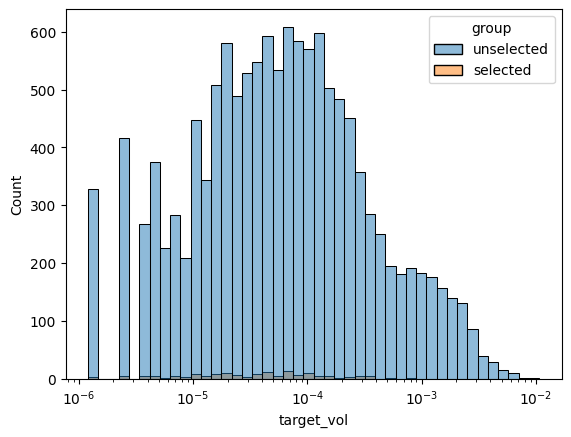

In [37]:
sns.histplot(data_a4, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

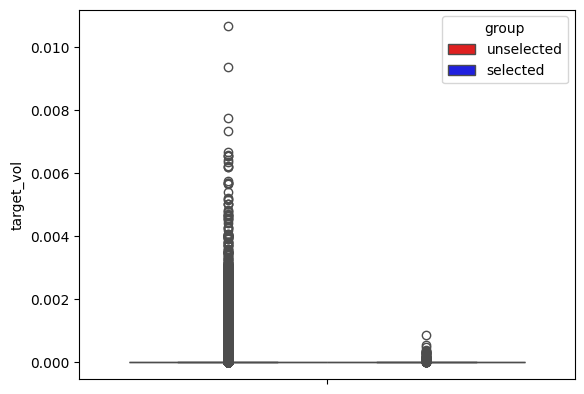

In [38]:
sns.boxplot(data_a4, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

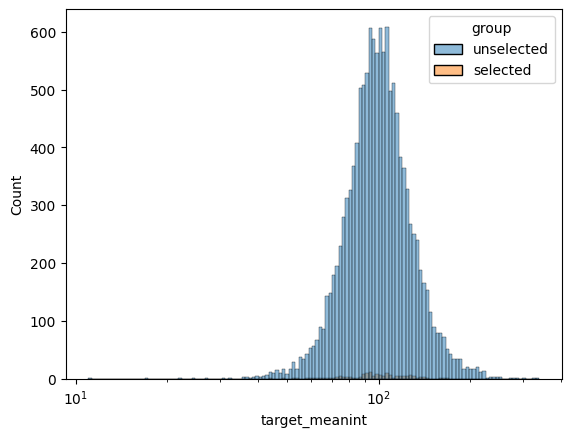

In [39]:
sns.histplot(data_a4, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

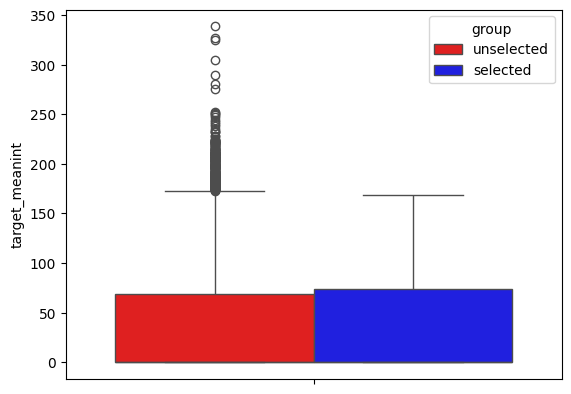

In [40]:
sns.boxplot(data_a4, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

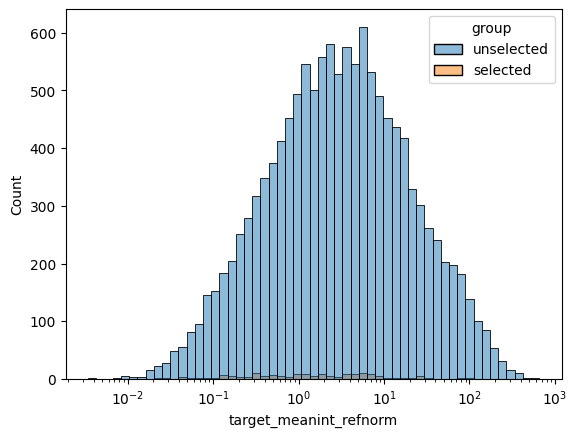

In [41]:
sns.histplot(data_a4, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

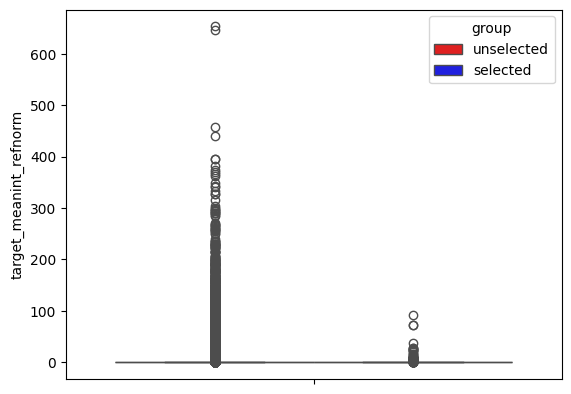

In [42]:
sns.boxplot(data_a4, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## 2. Stg

In [43]:
data_stg = data[data['prot']=='Stg']

<Axes: xlabel='target_vol', ylabel='Count'>

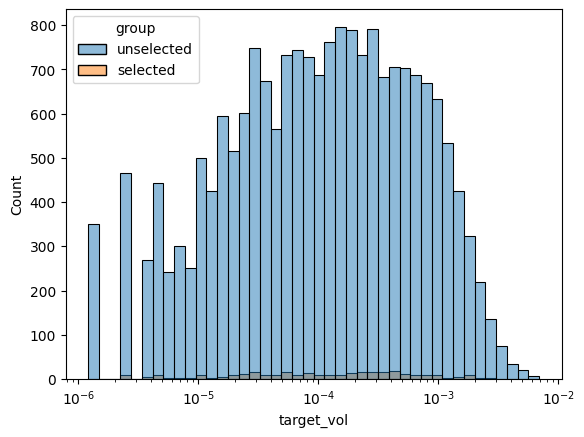

In [44]:
sns.histplot(data_stg, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

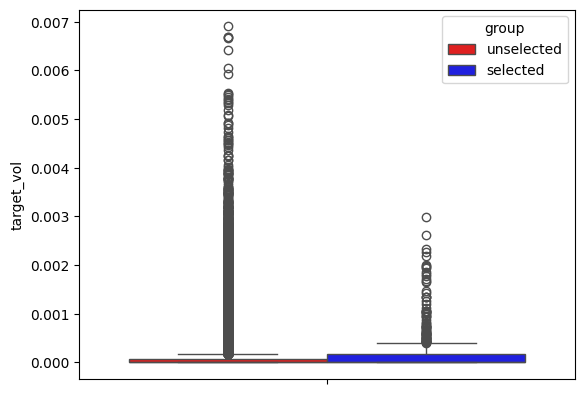

In [45]:
sns.boxplot(data_stg, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

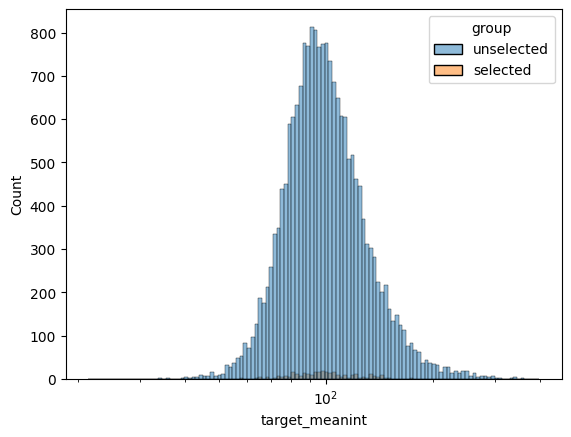

In [46]:
sns.histplot(data_stg, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

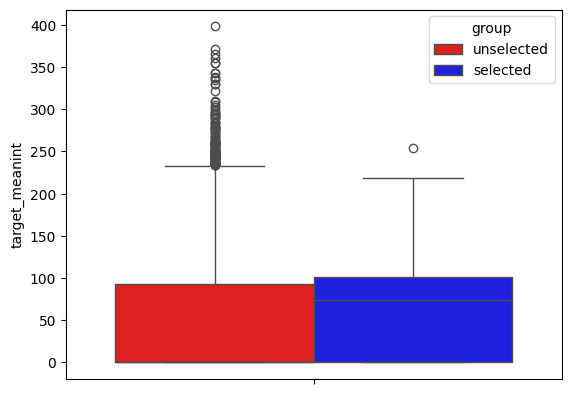

In [47]:
sns.boxplot(data_stg, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

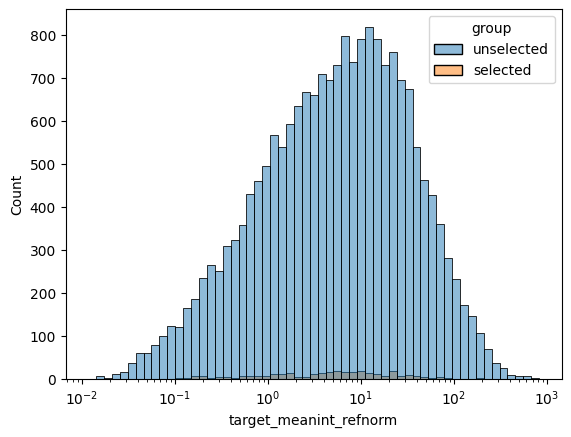

In [48]:
sns.histplot(data_stg, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

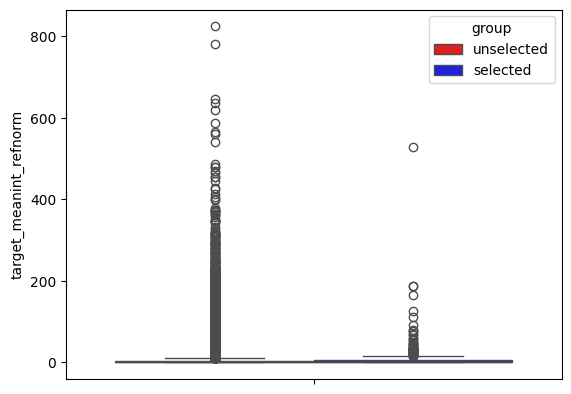

In [49]:
sns.boxplot(data_stg, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## 3. PSD95

In [50]:
data_95 = data[data['prot']=='PSD95']

<Axes: xlabel='target_vol', ylabel='Count'>

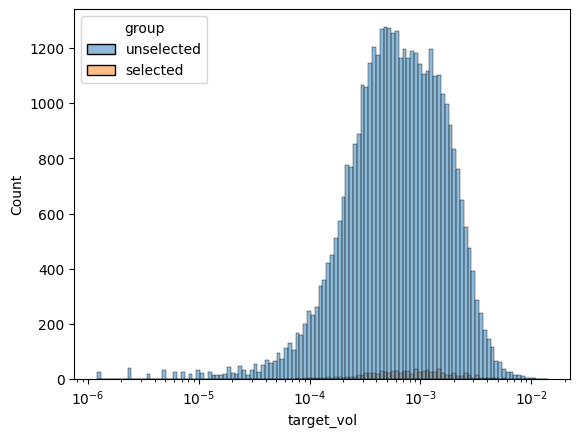

In [51]:
sns.histplot(data_95, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

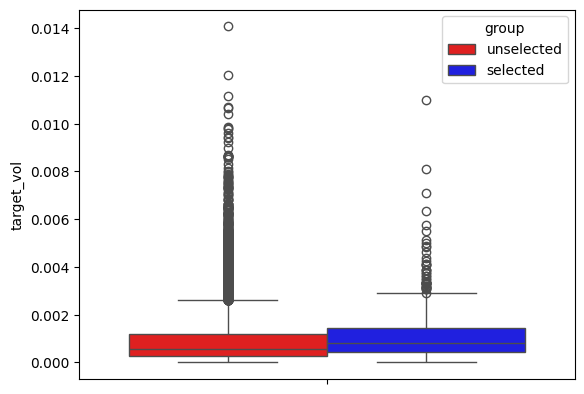

In [52]:
sns.boxplot(data_95, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

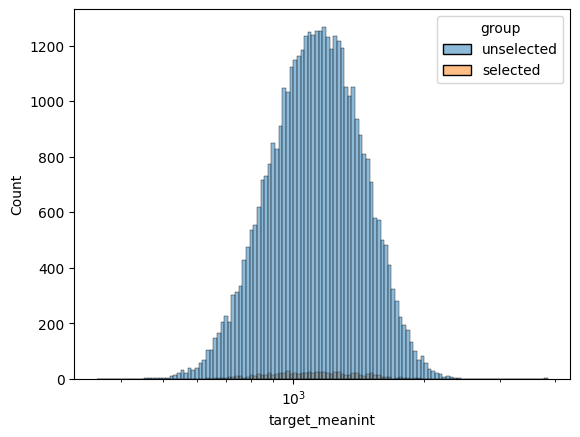

In [53]:
sns.histplot(data_95, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

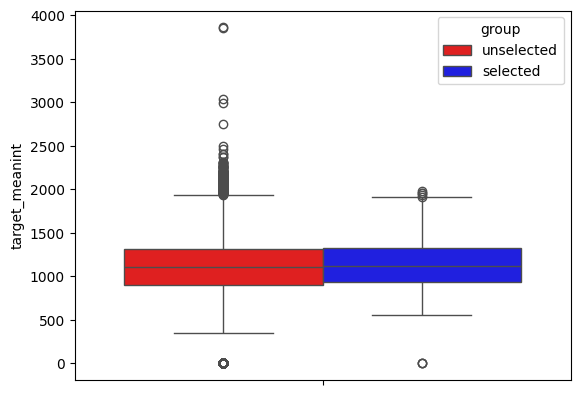

In [54]:
sns.boxplot(data_95, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

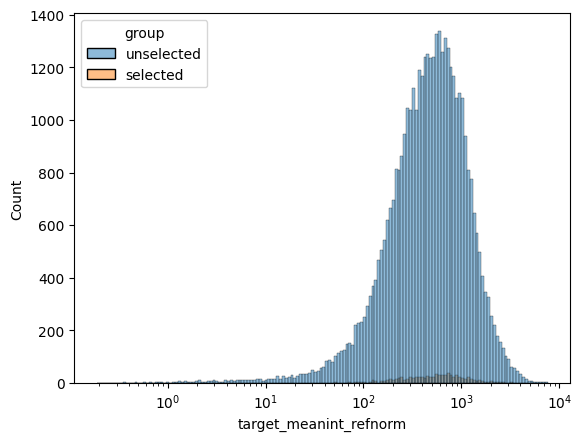

In [55]:
sns.histplot(data_95, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

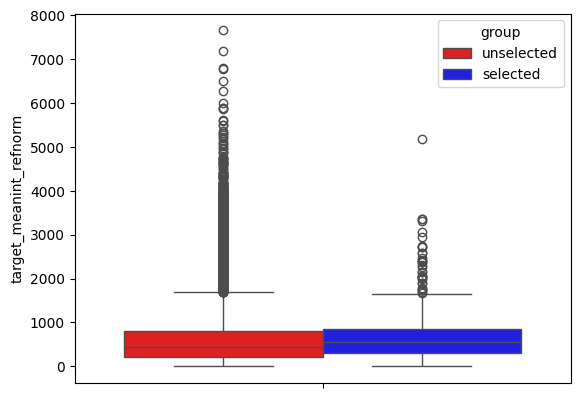

In [56]:
sns.boxplot(data_95, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## Create scatter plots of volume vs. mean intensity

<Axes: xlabel='target_vol', ylabel='target_meanint'>

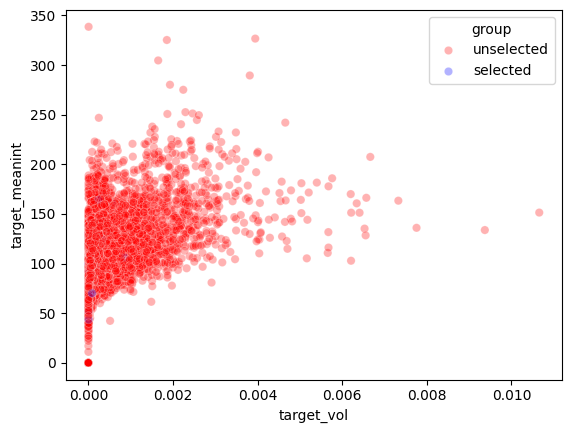

In [57]:
sns.scatterplot(data_a4,x='target_vol',y='target_meanint',hue="group",palette=['red','blue'],alpha=0.3)

# Test for statistically significant differences in these properties between synapse types

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
list(data)

['target_vol',
 'target_meanint',
 'target_meanint_refnorm',
 'target_npuncta',
 'selected_tf',
 'sample',
 'region',
 'roi_full',
 'fov',
 'syn',
 'prot',
 'group']

In [60]:
#approximate new alpha?
0.05 / (4*4)

0.003125

In [61]:
unadjusted_pvals = []
zscores = []

## 1. SSC

In [62]:
data_ctx = data[data['region']=='SSC']

In [63]:
data_ctx.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
Thy1GFP_SSC_GluA4_M1_006_fov002_pp_syn1,0.0,0.0,0.0,0.0,0.0,M1,SSC,M1-GluA4-fov002,fov002,syn1,GluA4,unselected
Thy1GFP_SSC_GluA4_M1_006_fov002_pp_syn2,0.0,0.0,0.0,0.0,0.0,M1,SSC,M1-GluA4-fov002,fov002,syn2,GluA4,unselected
Thy1GFP_SSC_GluA4_M1_006_fov002_pp_syn3,0.0,0.0,0.0,0.0,0.0,M1,SSC,M1-GluA4-fov002,fov002,syn3,GluA4,unselected
Thy1GFP_SSC_GluA4_M1_006_fov002_pp_syn4,0.0,0.0,0.0,0.0,0.0,M1,SSC,M1-GluA4-fov002,fov002,syn4,GluA4,unselected
Thy1GFP_SSC_GluA4_M1_006_fov002_pp_syn5,0.0,0.0,0.0,0.0,0.0,M1,SSC,M1-GluA4-fov002,fov002,syn5,GluA4,unselected


In [64]:
data_ctx['prot'].value_counts()

prot
Stg      16278
GluA4    14173
PSD95    13917
NR1      11215
Name: count, dtype: int64

### 1. GluA4

In [65]:
data_ctx_a4 = data_ctx[data_ctx['prot']=='GluA4']

In [66]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target_vol
No. Observations:   14173    Method:              REML      
No. Groups:         14       Scale:               0.0000    
Min. group size:    843      Log-Likelihood:      87982.9828
Max. group size:    1370     Converged:           Yes       
Mean group size:    1012.4                                  
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.000    0.000 0.745 0.457 -0.000  0.000
group[T.unselected] 0.000    0.000 3.067 0.002  0.000  0.000
Group Var           0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.45654044862212884
0.0021613034820018957


In [68]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 14173   Method:             REML                  
No. Groups:       14      Scale:              663.0542              
Min. group size:  843     Log-Likelihood:     -66161.4236           
Max. group size:  1370    Converged:          Yes                   
Mean group size:  1012.4                                            
---------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               1.225     2.006  0.610  0.542  -2.707   5.157
group[T.unselected]     5.848     1.945  3.008  0.003   2.037   9.659
Group Var               4.070     0.072                              



In [69]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.5415697524381118
0.002633590601696456


### 2. PSD95

In [70]:
data_ctx_95 = data_ctx[data_ctx['prot']=='PSD95']

In [71]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   target_vol
No. Observations:   13917     Method:               REML      
No. Groups:         13        Scale:                0.0000    
Min. group size:    879       Log-Likelihood:       73396.9358
Max. group size:    1426      Converged:            Yes       
Mean group size:    1070.5                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.002    0.000 18.252 0.000  0.001  0.002
group[T.unselected] -0.001    0.000 -6.482 0.000 -0.001 -0.000
Group Var            0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [72]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.0103767118668067e-74
9.033789343604986e-11


In [73]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 13917   Method:             REML                  
No. Groups:       13      Scale:              346840.2856           
Min. group size:  879     Log-Likelihood:     -108522.2777          
Max. group size:  1426    Converged:          Yes                   
Mean group size:  1070.5                                            
--------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------
Intercept             709.893   43.052 16.489 0.000  625.513 794.272
group[T.unselected]  -119.475   39.199 -3.048 0.002 -196.304 -42.645
Group Var            4451.232    3.301                              



In [74]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.374045021916306e-61
0.0023046169972308172


### 3. NR1

In [75]:
data_ctx_nr1 = data_ctx[data_ctx['prot']=='NR1']

In [76]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   target_vol
No. Observations:   11215     Method:               REML      
No. Groups:         13        Scale:                0.0000    
Min. group size:    623       Log-Likelihood:       64042.6581
Max. group size:    1159      Converged:            Yes       
Mean group size:    862.7                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.001    0.000 19.683 0.000  0.001  0.001
group[T.unselected] -0.000    0.000 -8.267 0.000 -0.001 -0.000
Group Var            0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [77]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.0142731785784667e-86
1.3791652670799754e-16


In [78]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 11215   Method:             REML                  
No. Groups:       13      Scale:              61804.7456            
Min. group size:  623     Log-Likelihood:     -77780.1020           
Max. group size:  1159    Converged:          Yes                   
Mean group size:  862.7                                             
--------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------
Intercept             264.134   19.117 13.817 0.000  226.664 301.603
group[T.unselected]  -106.975   18.102 -5.910 0.000 -142.454 -71.496
Group Var             550.636    1.025                              



In [79]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.026622615101669e-43
3.4301772446470642e-09


### 4. Stargazin

In [80]:
data_ctx_stg = data_ctx[data_ctx['prot']=='Stg']

In [81]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   target_vol
No. Observations:   16278     Method:               REML      
No. Groups:         15        Scale:                0.0000    
Min. group size:    611       Log-Likelihood:       98030.4627
Max. group size:    1349      Converged:            Yes       
Mean group size:    1085.2                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.000    0.000 10.500 0.000  0.000  0.001
group[T.unselected] -0.000    0.000 -1.864 0.062 -0.000  0.000
Group Var            0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [82]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

8.643085689603635e-26
0.062381899777239694


In [83]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 16278   Method:             REML                  
No. Groups:       15      Scale:              1690.4464             
Min. group size:  611     Log-Likelihood:     -83613.4042           
Max. group size:  1349    Converged:          Yes                   
Mean group size:  1085.2                                            
---------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept              17.971     3.226  5.571  0.000  11.648  24.295
group[T.unselected]     1.438     2.752  0.522  0.601  -3.957   6.832
Group Var              44.050     0.419                              



In [84]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.5386644321173255e-08
0.6014181488007185


#### Compile p-values

In [85]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm',
        'Stg_vol',
    'Stg_meanint_refnorm',
]

In [86]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [87]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [88]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ssc_selectedvsunselected_lmer_pvals.csv')

In [89]:
prots = unique(data['prot'])

In [90]:
prots

['Stg', 'PSD95', 'NR1', 'GluA4']

In [91]:
values = ['target_vol','target_meanint_refnorm']

In [92]:
group_colors = ['blue','red']

In [93]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,2.161303e-03,3.067,3.511454e-03,True
GluA4_meanint_refnorm,2.633591e-03,3.008,3.511454e-03,True
PSD95_vol,9.033789e-11,-6.482,3.613516e-10,True
PSD95_meanint_refnorm,2.304617e-03,-3.048,3.511454e-03,True
NR1_vol,1.379165e-16,-8.267,1.103332e-15,True
NR1_meanint_refnorm,3.430177e-09,-5.910,9.147139e-09,True
Stg_vol,6.238190e-02,-1.864,7.129360e-02,False
Stg_meanint_refnorm,6.014181e-01,0.522,6.014181e-01,False


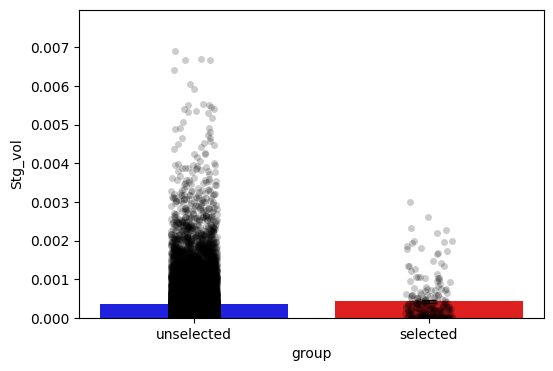

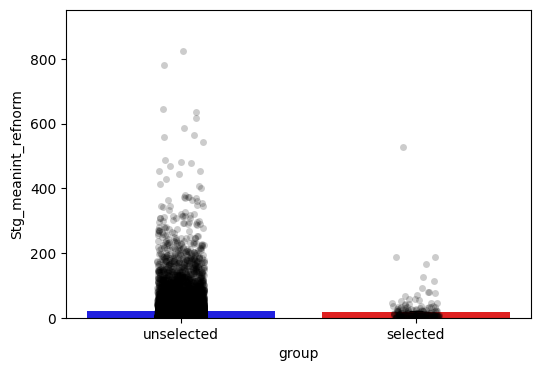

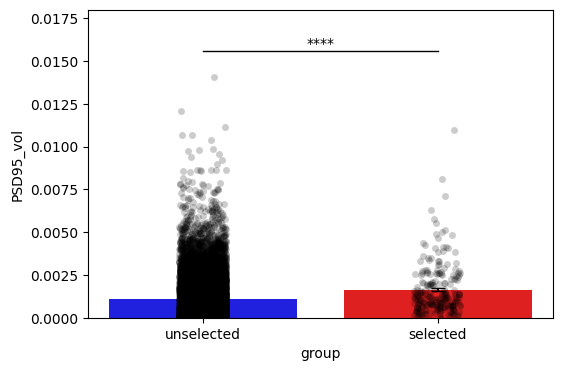

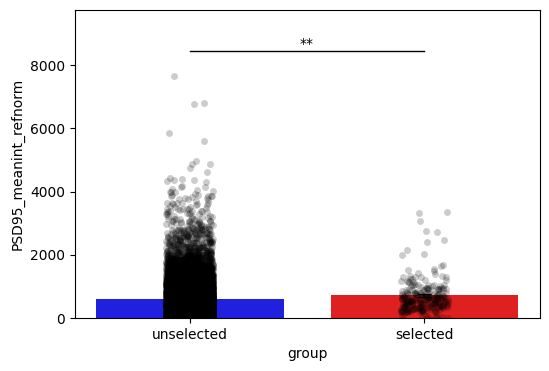

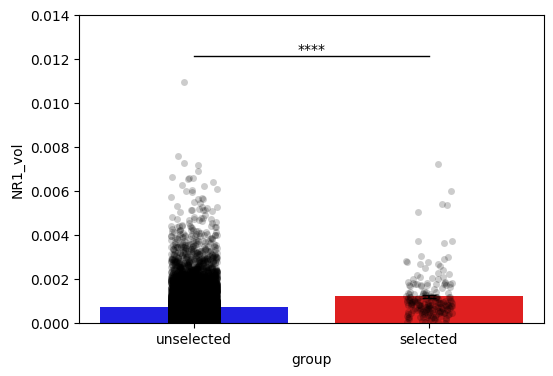

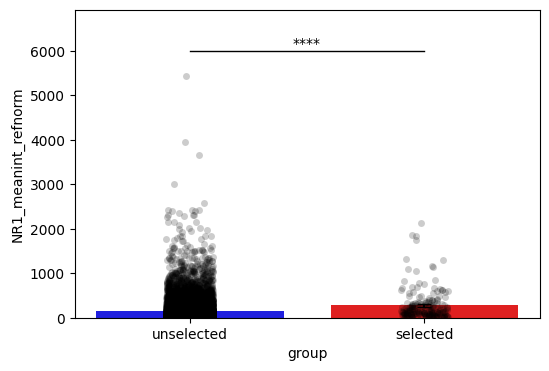

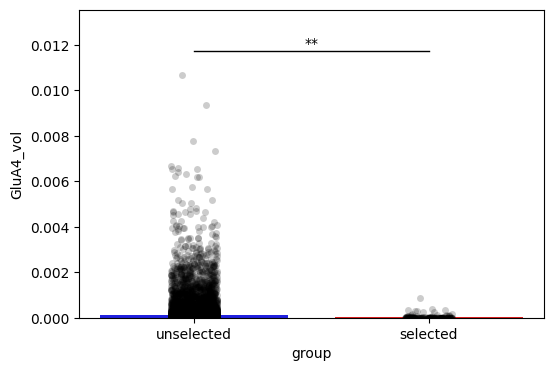

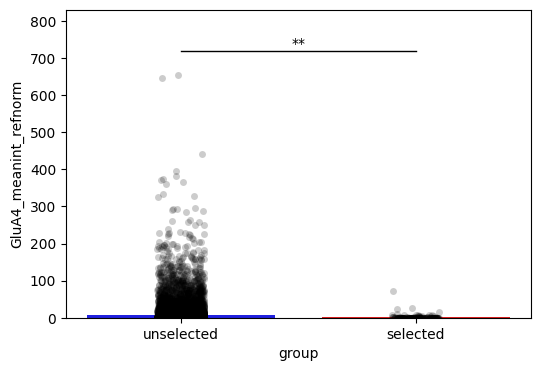

In [94]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ctx[data_ctx['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

## 2. CA1

In [95]:
unadjusted_pvals = []
zscores = []

In [96]:
data_ca1 = data[data['region']=='CA1']

In [97]:
data_ca1.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn1,0.000017,101.0,0.937044,1.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn1,GluA4,unselected
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn2,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn2,GluA4,unselected
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn3,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn3,GluA4,unselected
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn4,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn4,GluA4,unselected
Thy1GFP_CA1_GluA4_M1_005_fov001_pp_syn5,0.000000,0.0,0.000000,0.0,0.0,M1,CA1,M1-GluA4-fov001,fov001,syn5,GluA4,unselected


In [98]:
data_ca1['prot'].value_counts()

prot
GluA4    34561
PSD95    32069
Stg      29482
NR1      28791
Name: count, dtype: int64

### 1. GluA4

In [99]:
data_ca1_a4 = data_ca1[data_ca1['prot']=='GluA4']

In [100]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  target_vol 
No. Observations:  34561    Method:              REML       
No. Groups:        19       Scale:               0.0000     
Min. group size:   1414     Log-Likelihood:      243829.2470
Max. group size:   2190     Converged:           Yes        
Mean group size:   1819.0                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.000    0.000 1.597 0.110 -0.000  0.000
group[T.unselected] 0.000    0.000 1.691 0.091 -0.000  0.000
Group Var           0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [101]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.11031140573150719
0.09090390419272097


In [102]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 34561   Method:             REML                  
No. Groups:       19      Scale:              186.1738              
Min. group size:  1414    Log-Likelihood:     -139384.3332          
Max. group size:  2190    Converged:          Yes                   
Mean group size:  1819.0                                            
---------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               1.532     0.751  2.041  0.041   0.061   3.003
group[T.unselected]     0.853     0.701  1.218  0.223  -0.520   2.226
Group Var               1.483     0.039                              



In [103]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.041236697808630256
0.2234025443965323


### 2. PSD95

In [104]:
data_ca1_95 = data_ca1[data_ca1['prot']=='PSD95']

In [105]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  target_vol 
No. Observations:    32069    Method:              REML       
No. Groups:          19       Scale:               0.0000     
Min. group size:     440      Log-Likelihood:      188235.9568
Max. group size:     2021     Converged:           Yes        
Mean group size:     1687.8                                   
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.001    0.000 28.684 0.000  0.001  0.001
group[T.unselected] -0.000    0.000 -5.908 0.000 -0.000 -0.000
Group Var            0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [106]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

5.961081732566296e-181
3.462866261258628e-09


In [107]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 32069   Method:             REML                  
No. Groups:       19      Scale:              307776.9783           
Min. group size:  440     Log-Likelihood:     -248177.3851          
Max. group size:  2021    Converged:          Yes                   
Mean group size:  1687.8                                            
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              676.142   56.960 11.870 0.000 564.502 787.782
group[T.unselected]    -50.739   23.338 -2.174 0.030 -96.481  -4.997
Group Var            51463.084   31.423                             



In [108]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.6855258981589962e-32
0.029700379453761607


### 3. NR1

In [109]:
data_ca1_nr1 = data_ca1[data_ca1['prot']=='NR1']

In [110]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  target_vol 
No. Observations:    28791    Method:              REML       
No. Groups:          19       Scale:               0.0000     
Min. group size:     1065     Log-Likelihood:      182872.2300
Max. group size:     1926     Converged:           Yes        
Mean group size:     1515.3                                   
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.001    0.000 29.249 0.000  0.001  0.001
group[T.unselected] -0.000    0.000 -8.017 0.000 -0.000 -0.000
Group Var            0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [111]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.618927254347084e-188
1.0804544708516406e-15


In [112]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 28791   Method:             REML                  
No. Groups:       19      Scale:              26601.7702            
Min. group size:  1065    Log-Likelihood:     -187553.8627          
Max. group size:  1926    Converged:          Yes                   
Mean group size:  1515.3                                            
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              234.548   10.194 23.008 0.000 214.567 254.528
group[T.unselected]    -46.321    7.998 -5.792 0.000 -61.996 -30.645
Group Var              776.540    1.625                             



In [113]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.881861431907738e-117
6.967585697068623e-09


### 4. Stargazin

In [114]:
data_ca1_stg = data_ca1[data_ca1['prot']=='Stg']

In [115]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  target_vol 
No. Observations:  29482    Method:              REML       
No. Groups:        17       Scale:               0.0000     
Min. group size:   1522     Log-Likelihood:      207870.1069
Max. group size:   1850     Converged:           Yes        
Mean group size:   1734.2                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.000    0.000 1.317 0.188 -0.000  0.000
group[T.unselected] 0.000    0.000 1.894 0.058 -0.000  0.000
Group Var           0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [116]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.18796493123342906
0.05825378541372408


In [117]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 29482   Method:             REML                  
No. Groups:       17      Scale:              137.2448              
Min. group size:  1522    Log-Likelihood:     -114408.9217          
Max. group size:  1850    Converged:          Yes                   
Mean group size:  1734.2                                            
---------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               0.968     0.697  1.390  0.165  -0.397   2.333
group[T.unselected]     1.104     0.636  1.737  0.082  -0.142   2.350
Group Var               1.458     0.046                              



In [118]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.16467857808020825
0.08247285344853093


#### Compile p-values

In [119]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm',
        'Stg_vol',
    'Stg_meanint_refnorm',
]

In [120]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [121]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [122]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ca1_selectedvsunselected_lmer_pvals.csv')

In [123]:
prots = unique(data['prot'])

In [124]:
prots

['Stg', 'PSD95', 'NR1', 'GluA4']

In [125]:
values = ['target_vol','target_meanint_refnorm']

In [126]:
group_colors = ['blue','red']

In [127]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,9.090390e-02,1.691,1.038902e-01,False
GluA4_meanint_refnorm,2.234025e-01,1.218,2.234025e-01,False
PSD95_vol,3.462866e-09,-5.908,1.385147e-08,True
PSD95_meanint_refnorm,2.970038e-02,-2.174,5.940076e-02,False
NR1_vol,1.080454e-15,-8.017,8.643636e-15,True
NR1_meanint_refnorm,6.967586e-09,-5.792,1.858023e-08,True
Stg_vol,5.825379e-02,1.894,9.320606e-02,False
Stg_meanint_refnorm,8.247285e-02,1.737,1.038902e-01,False


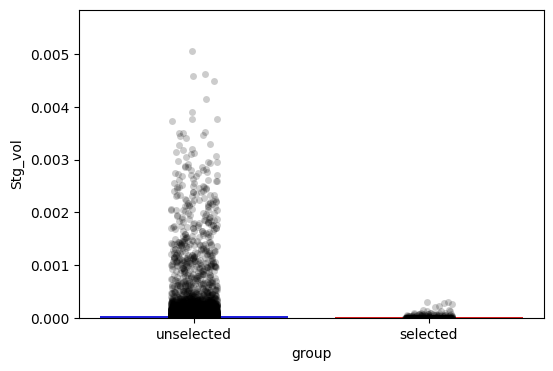

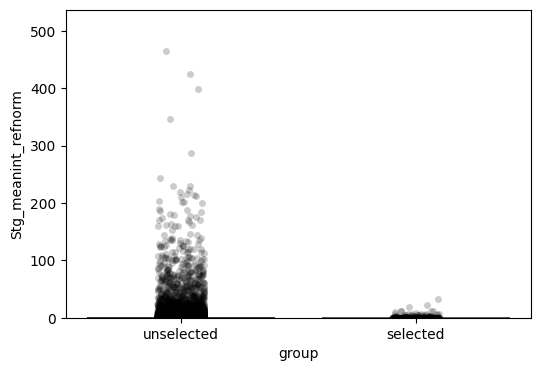

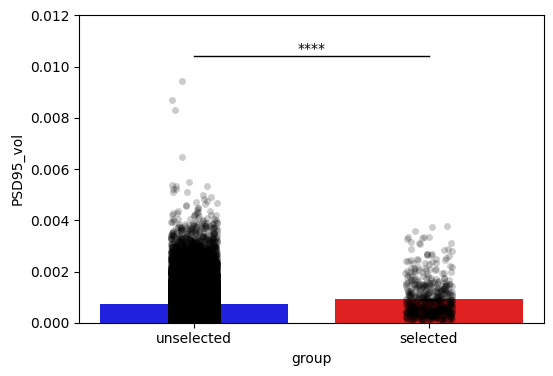

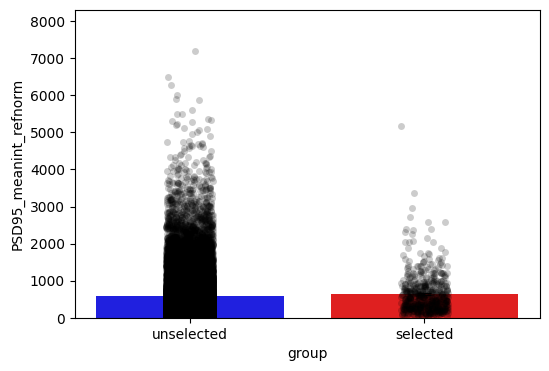

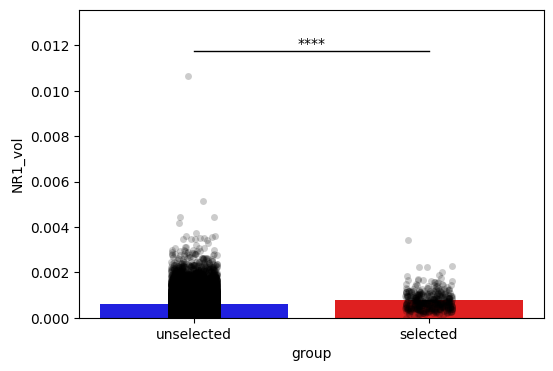

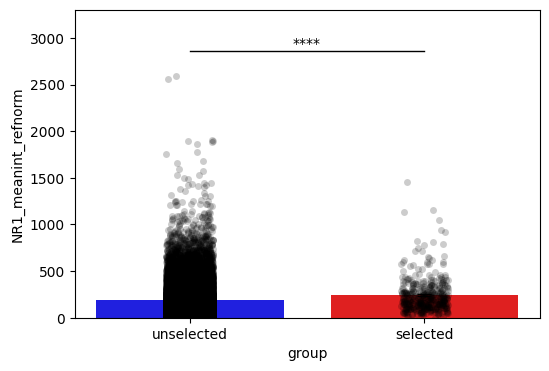

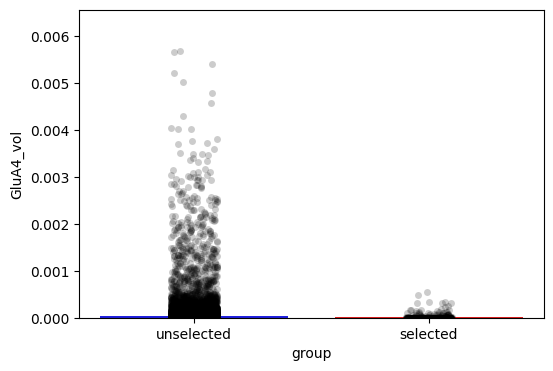

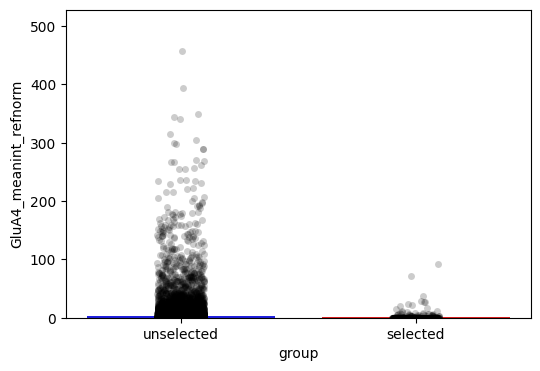

In [128]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Identify numerical columns in 'data_ca1'
numerical_columns = data_ca1.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ca1['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ca1[data_ca1['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ca1 points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

# Save down data as .csv to folder to combine with other datasets

In [129]:
data.to_csv('/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/PV_vs_Thy1_combined/Thy1_YFP_4target.csv')